# Import needed modules

In [1]:
!pip install tensorflow==2.9.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.9.1


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [11]:
train_dir = 'D:\\Data Science\\Deep Learning Projects\\Pneumonia-detection\\Covid19-dataset\\train'
filepaths = []
labels = []

folds = os.listdir(train_dir)

for fold in folds:
    foldpath = os.path.join(train_dir, fold)    
    filelist = os.listdir(foldpath)  
    for file in filelist:        
        fpath = os.path.join(foldpath, file)        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
train_df

,filepaths,labels
0,D:\Data Science\Deep Learning Projects\Video C...,Covid
1,D:\Data Science\Deep Learning Projects\Video C...,Covid
2,D:\Data Science\Deep Learning Projects\Video C...,Covid
3,D:\Data Science\Deep Learning Projects\Video C...,Covid
4,D:\Data Science\Deep Learning Projects\Video C...,Covid
...,...,...
246,D:\Data Science\Deep Learning Projects\Video C...,Viral Pneumonia
247,D:\Data Science\Deep Learning Projects\Video C...,Viral Pneumonia
248,D:\Data Science\Deep Learning Projects\Video C...,Viral Pneumonia
249,D:\Data Science\Deep Learning Projects\Video C...,Viral Pneumonia


In [14]:
# Generate  test data paths with labels
test_dir = 'D:\\Data Science\\Deep Learning Projects\\Pneumonia-detection\\Covid19-dataset\\test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [15]:
test_df

,filepaths,labels
0,D:\Data Science\Deep Learning Projects\Pneumon...,Covid
1,D:\Data Science\Deep Learning Projects\Pneumon...,Covid
2,D:\Data Science\Deep Learning Projects\Pneumon...,Covid
3,D:\Data Science\Deep Learning Projects\Pneumon...,Covid
4,D:\Data Science\Deep Learning Projects\Pneumon...,Covid
...,...,...
61,D:\Data Science\Deep Learning Projects\Pneumon...,Viral Pneumonia
62,D:\Data Science\Deep Learning Projects\Pneumon...,Viral Pneumonia
63,D:\Data Science\Deep Learning Projects\Pneumon...,Viral Pneumonia
64,D:\Data Science\Deep Learning Projects\Pneumon...,Viral Pneumonia


**Split dataframe into train, valid, and test**

In [16]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [17]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 251 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


**Show sample from train data**

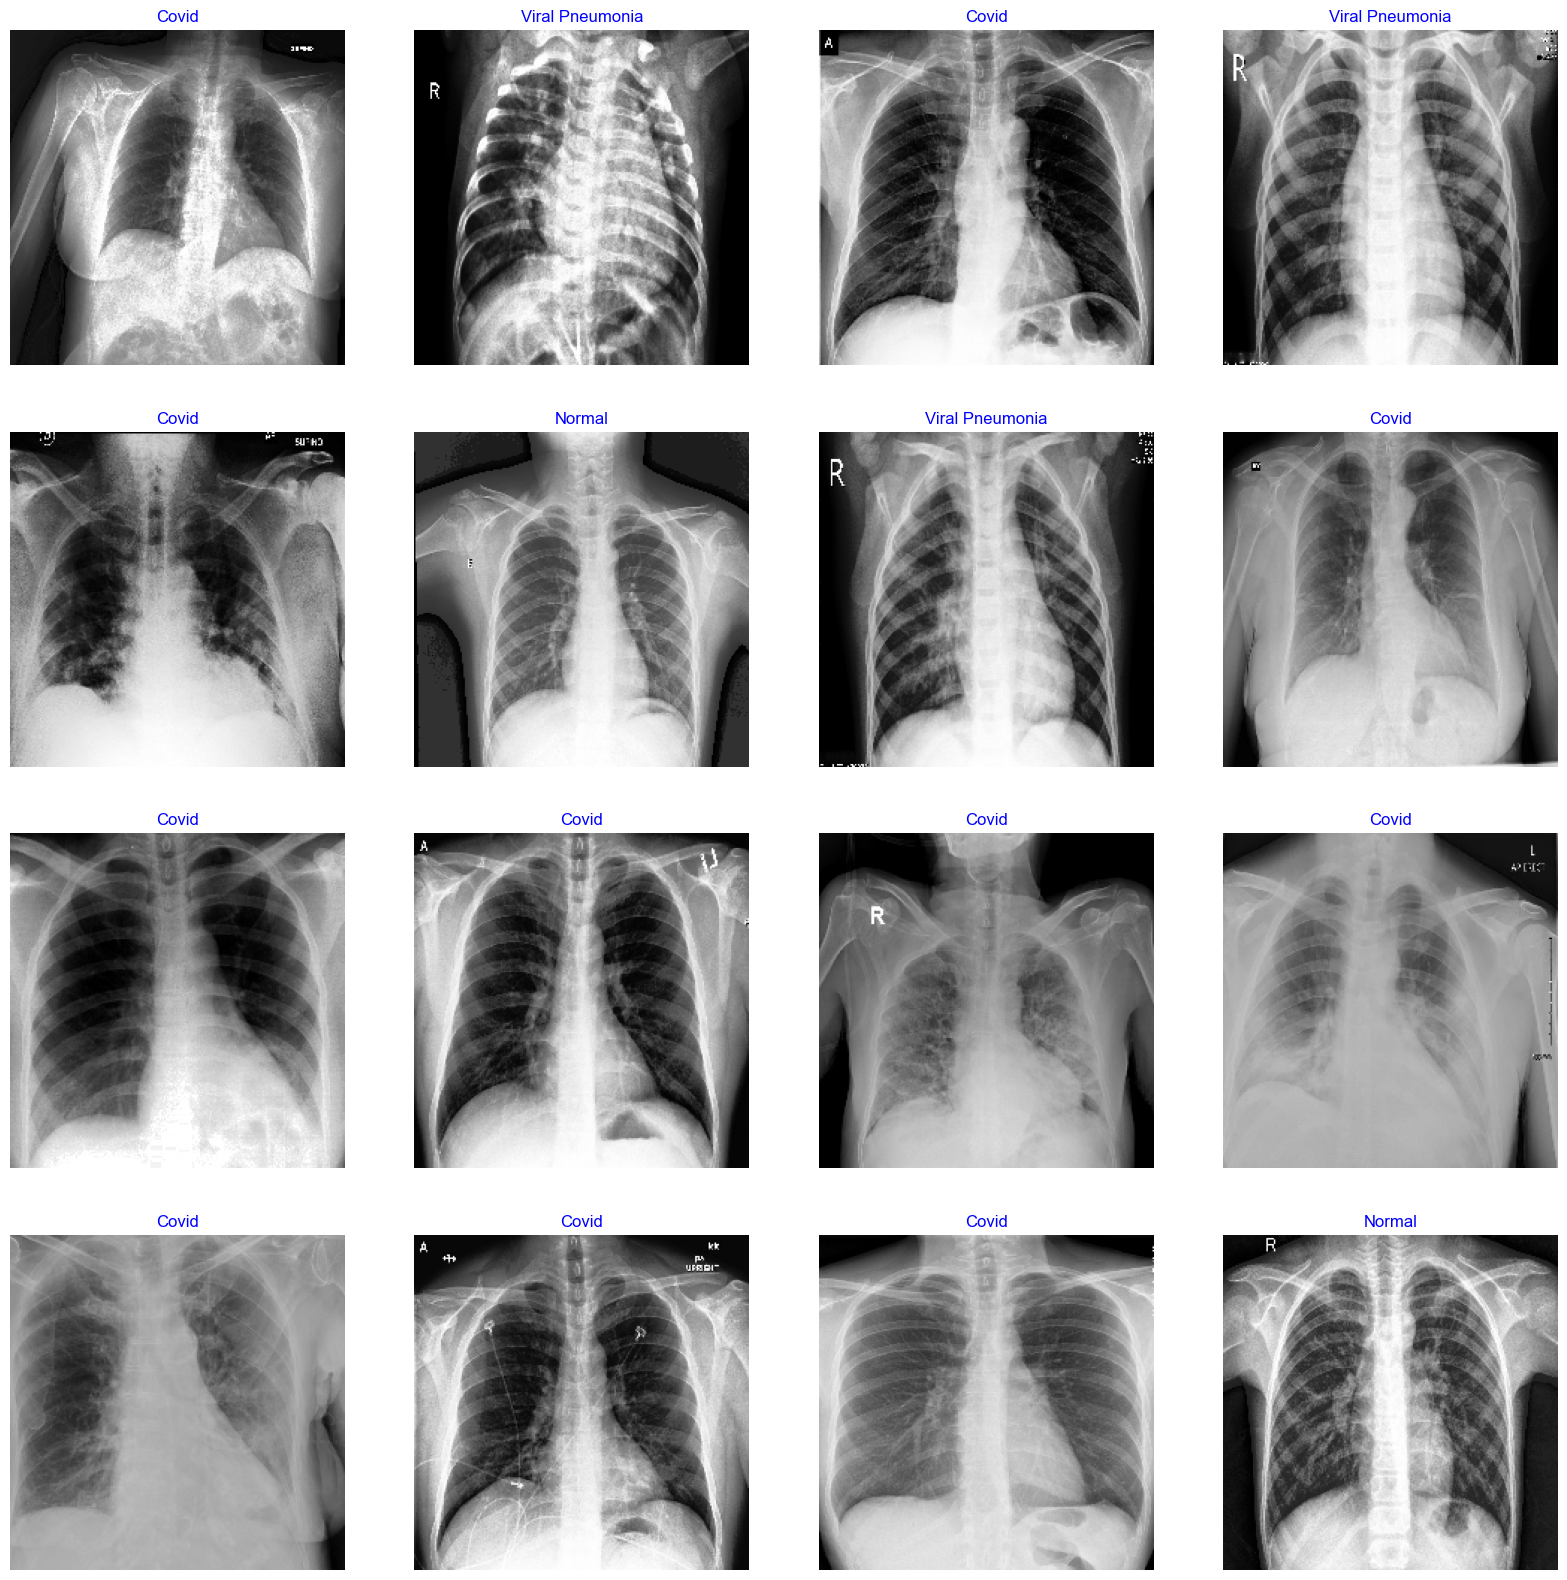

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [19]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4383398 (16.72 MB)
Trainable params: 4

**Train model**

In [14]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/20

16/16 [==============================] - 71s 3s/step - loss: 8.2360 - accuracy: 0.7371 - val_loss: 9.5770 - val_accuracy: 0.3333
Epoch 2/20
16/16 [==============================] - 37s 2s/step - loss: 7.4659 - accuracy: 0.9004 - val_loss: 8.6454 - val_accuracy: 0.4615
Epoch 3/20
16/16 [==============================] - 38s 2s/step - loss: 6.9954 - accuracy: 0.9243 - val_loss: 7.8600 - val_accuracy: 0.5128
Epoch 4/20
16/16 [==============================] - 36s 2s/step - loss: 6.5584 - accuracy: 0.9641 - val_loss: 7.6155 - val_accuracy: 0.4359
Epoch 5/20
16/16 [==============================] - 36s 2s/step - loss: 6.3017 - accuracy: 0.9562 - val_loss: 7.1070 - val_accuracy: 0.5128
Epoch 6/20
16/16 [==============================] - 30s 2s/step - loss: 5.9279 - accuracy: 0.9801 - val_loss: 6.6685 - val_accuracy: 0.5385
Epoch 7/20
16/16 [==============================] - 36s 2s/step - loss: 5.6220 - accuracy: 1.0000 - val_loss: 6.4482 - val_accuracy: 0.5385
Epoch 8/20
16/16 [=

**Display model performance**

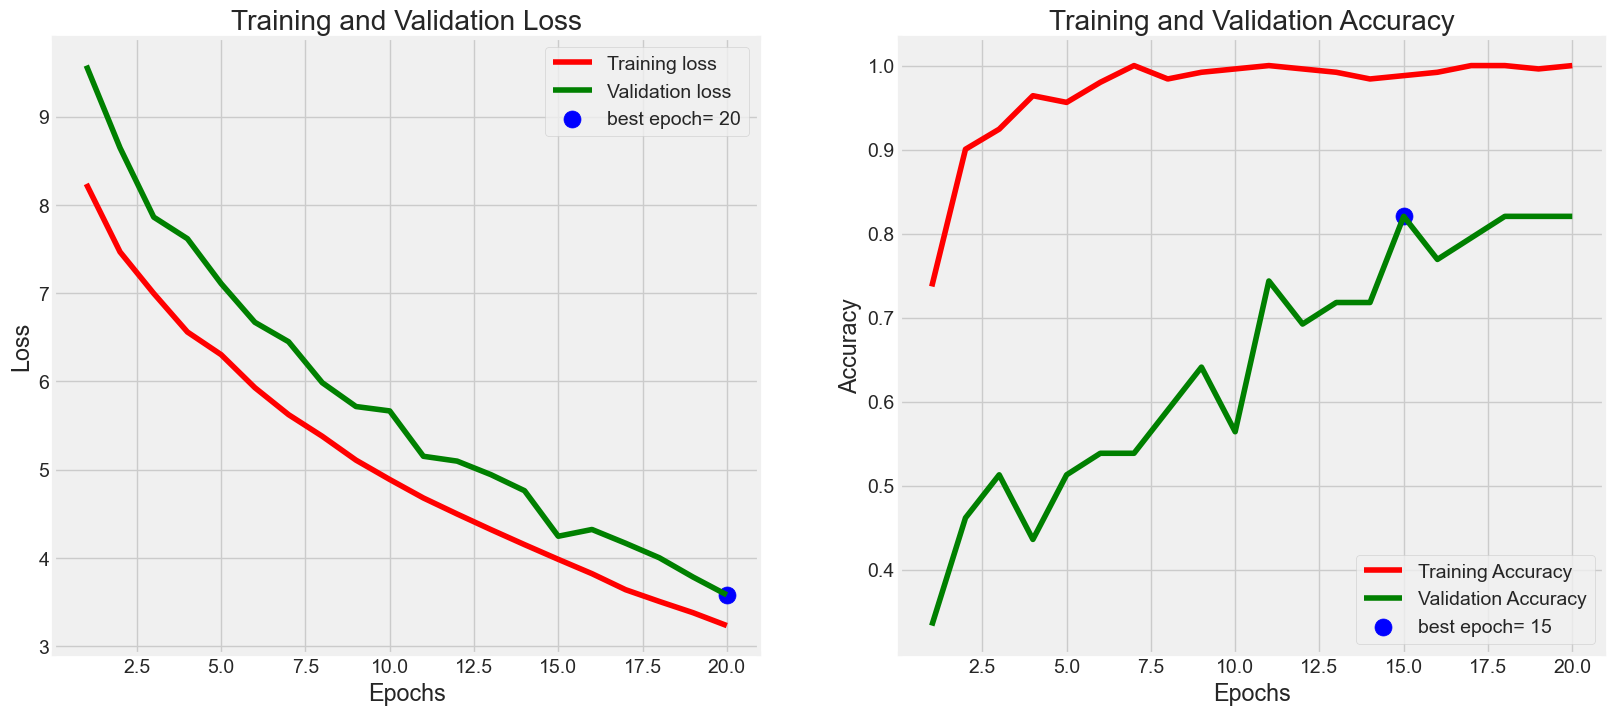

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate model

In [22]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

27
27
1
1/1 [==============================] - 1s 874ms/step - loss: 11.3867 - accuracy: 0.1875
Train Loss:  10.049005508422852
Train Accuracy:  0.5
--------------------
Validation Loss:  10.476823806762695
Validation Accuracy:  0.5
--------------------
Test Loss:  11.386683464050293
Test Accuracy:  0.1875


**Get Predictions**

In [26]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


**Confusion Matrics and Classification Report**

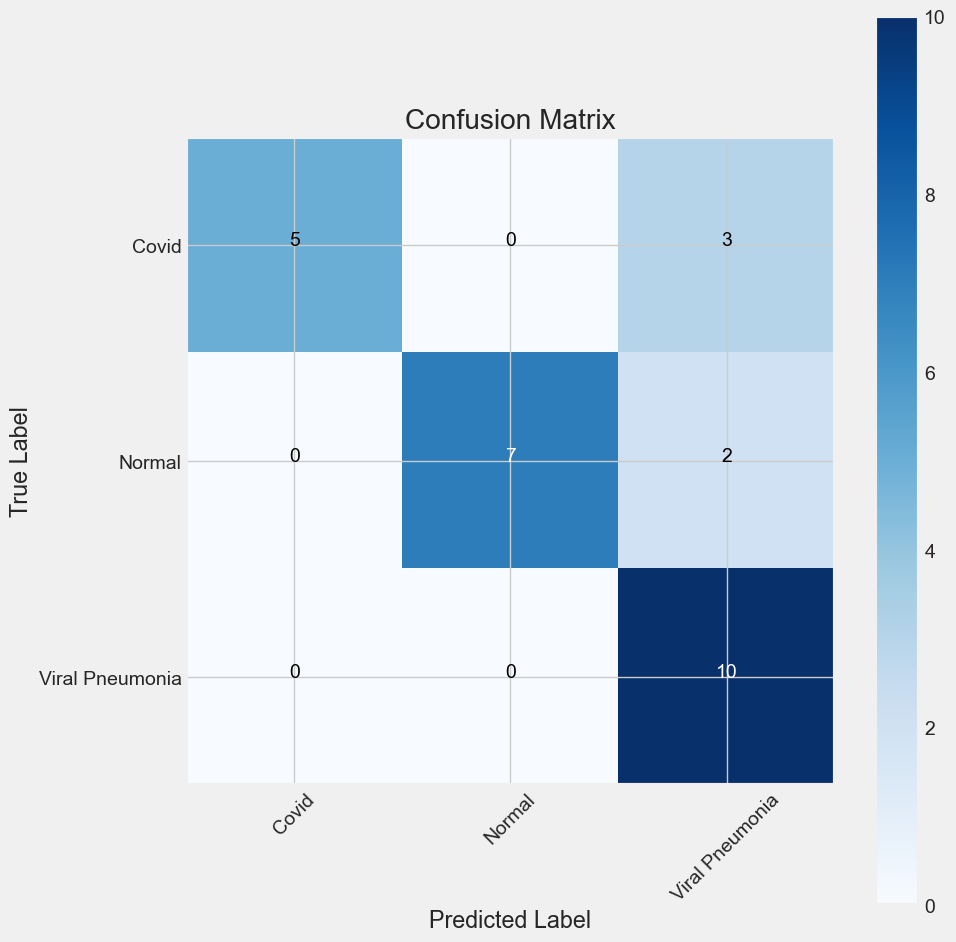

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

          Covid       1.00      0.62      0.77         8
         Normal       1.00      0.78      0.88         9
Viral Pneumonia       0.67      1.00      0.80        10

       accuracy                           0.81        27
      macro avg       0.89      0.80      0.81        27
   weighted avg       0.88      0.81      0.82        27



**Save model**

In [20]:
#Save the model
model.save('model.h5')

# Prediction using loaded_model

In [23]:
loaded_model = tf.keras.models.load_model('D:\\Data Science\\Deep Learning Projects\\Video Classification\\notebook\\model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [28]:
image_path = 'C:\\Users\\varsh\\Downloads\\xray.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
Covid


If you found it helpful, do upvote

Feel free to comment

I would love to have suggestions.